# GNN
---

## Import

In [1]:
import torch
import matplotlib.pyplot as plt
#import networkx as nx
import numpy as np
import pandas as pd
from torch_geometric.loader import DataLoader
from torch_geometric.loader import NeighborLoader
from torch_geometric.data import Data
from models import *
from umap import UMAP
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

/home/lucamodica/mambaforge/envs/rigged/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read, understand and prepare the data

In [2]:
# node_data = pd.read_parquet('data/amazon_product_data_word2vec.parquet')
data: Data = torch.load('data/amazon_product_data_sum_all.pt')
data.num_classes = data.y.unique().shape[0]

/tmp/ipykernel_578022/3584924936.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data: Data = torch.load('data/amazon_product_data_sum_all.pt')


### Main info

In [3]:
print("data", data)
print("num nodes", data.num_nodes)
print("Num edges", data.num_edges)
print("num node features", data.num_node_features)
print("is undirected", data.is_undirected())
print("is directed", data.is_directed())
print("num edge features", data.num_edge_features)
print('num classes', data.num_classes)

data Data(x=[729819, 300], edge_index=[2, 680548], y=[729819], num_classes=10)
num nodes 729819
Num edges 680548
num node features 300
is undirected False
is directed True
num edge features 0
num classes 10


### Visualization

In [4]:
def plot_class_distribution(raw_data: pd.DataFrame):
  value_counts = raw_data['main_category'].value_counts()
  
  plt.figure(figsize=(15, 6))
  plt.bar(value_counts.index, value_counts.values)
  plt.xticks([])
  plt.title('Class Distribution')
  plt.show()

def visualize(h, color, additional_text=None):
  z = UMAP(n_components=2).fit_transform(h.detach().cpu().numpy())

  plt.figure(figsize=(8, 8))
  plt.xticks([])
  plt.yticks([])

  plt.title(f'Embedding visualizaation {additional_text}')
  plt.scatter(z[:, 0], z[:, 1], s=50, c=color, cmap="Set2", label=color)
  plt.show()

In [5]:
# plot_class_distribution(node_data)

### Preparation for model training

In [6]:
def create_masks(data, train_ratio, val_ratio):
  num_nodes = data.num_nodes
  indices = list(range(num_nodes))
  np.random.shuffle(indices)
  
  # Create masks
  train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  test_mask = torch.zeros(num_nodes, dtype=torch.bool)
  
  # Set proportions for train, val, and test
  train_end = int(train_ratio * num_nodes)
  val_end = train_end + int(val_ratio * num_nodes)
  train_mask[indices[:train_end]] = True
  val_mask[indices[train_end:val_end]] = True
  test_mask[indices[val_end:]] = True
  
  # Assign the custom masks to the dataset
  data.train_mask = train_mask
  data.val_mask = val_mask
  data.test_mask = test_mask


def train_test_split_graph(data: Data, train_ratio: float, val_ratio: float, batch_size: int):
    """
    Split the graph data into train, validation, and test sets
    :param data: The graph data
    :param train_ratio: The ratio of the training set
    :param val_ratio: The ratio of the validation set
    :param batch_size: The batch size
    
    :return: The train, validation, and test data loaders
    """

    # Call the function to create masks
    create_masks(data, train_ratio, val_ratio)

    # train, validation, and test node indices based on the masks
    train_idx = data.train_mask.nonzero(as_tuple=False).view(-1)
    val_idx = data.val_mask.nonzero(as_tuple=False).view(-1)
    test_idx = data.test_mask.nonzero(as_tuple=False).view(-1)
    
    def create_data_loader(data, indices):
        return DataLoader(data[indices], batch_size=batch_size, shuffle=True)
      
    def create_neighbor_loader(data, indices, batch_size=batch_size):
        return NeighborLoader(data, num_neighbors=[30] * 2, batch_size=batch_size, input_nodes=indices)

    # create the data loaders
    train_loader = create_neighbor_loader(data, train_idx)
    val_loader = create_neighbor_loader(data, val_idx, batch_size=4096*2)
    test_loader = create_neighbor_loader(data, test_idx)

    return train_loader, val_loader, test_loader

## Model training

### Training functions

In [7]:
from sklearn.metrics import f1_score, balanced_accuracy_score


def accuracy(predictions, labels):
    correct = (predictions.argmax(dim=1) == labels).sum().item()
    total = labels.size(0)
    return correct / total


def f1(predictions, labels):
    preds = predictions.argmax(dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    return f1_score(labels, preds, average='weighted')
  
def balanced_accuracy(predictions, labels):
    preds = predictions.argmax(dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    return balanced_accuracy_score(labels, preds)

In [8]:
# print the size of the validation set
train_loader, val_loader, test_loader = train_test_split_graph(data, 0.8, 0.1, 4096)
print("Validation set size", len(val_loader.dataset))

Validation set size 72981


/home/lucamodica/mambaforge/envs/rigged/lib/python3.11/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [9]:
# visualize the embedding of the last batch in the validation loader
# for batch in val_loader:
#   h = batch.x
#   color = batch.y
  
# visualize(h, color, '(before training)')

In [10]:
def train_epoch(model, optimizer, loss_fn, train_loader, device, metrics):
    model.train()
    all_preds = []
    all_labels = []
    losses = []

    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        out, h = model(batch.x, batch.edge_index)  # Receive only one output
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        all_preds.append(out.detach().cpu())
        all_labels.append(batch.y.detach().cpu())
        
    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Compute metrics on the entire dataset
    avg_metrics = {metric_name: metric_fn(all_preds, all_labels) 
                  for metric_name, metric_fn in metrics.items()}
    avg_loss = np.mean(losses)

    return avg_loss, avg_metrics

@torch.no_grad()
def validate(model, loss_fn, val_loader: NeighborLoader, device, metrics, epoch=0):
    model.eval()
    all_preds = []
    all_labels = []
    losses = []

    for batch in val_loader:
        batch = batch.to(device)
        out, h = model(batch.x, batch.edge_index)
        loss = loss_fn(out, batch.y)

        losses.append(loss.item())
        all_preds.append(out.detach().cpu())
        all_labels.append(batch.y.detach().cpu())
        
    with torch.no_grad():
      _, h = model(batch.x, batch.edge_index)
      visualize(h, batch.y, (f'Epoch {epoch}, {model.__class__.__name__}'))

    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Compute metrics on the entire dataset
    avg_metrics = {metric_name: metric_fn(all_preds, all_labels) 
                  for metric_name, metric_fn in metrics.items()}
    avg_loss = np.mean(losses)

    return avg_loss, avg_metrics

def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, device, metrics):
    print("Starting training")
    train_losses, val_losses = [], []
    train_metrics_history = {metric_name: [] for metric_name in metrics}
    val_metrics_history = {metric_name: [] for metric_name in metrics}

    for epoch in range(1, num_epochs + 1):
        # Training
        train_loss, train_metrics = train_epoch(
            model, optimizer, loss_fn, train_loader, device, metrics)
        # Validation
        val_loss, val_metrics = validate(
            model, loss_fn, val_loader, device, metrics, epoch)
        
        # Logging results
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        for metric_name in metrics:
            train_metrics_history[metric_name].append(train_metrics[metric_name])
            val_metrics_history[metric_name].append(val_metrics[metric_name])

        # Print metrics
        metrics_str = ', '.join(
            [f'{metric_name}: {train_metrics[metric_name]:.3f} (train), {val_metrics[metric_name]:.3f} (val)'
             for metric_name in metrics])
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Loss: {train_loss:.3f} (train), {val_loss:.3f} (val), "
            f"{metrics_str}"
        )

    return model, train_losses, val_losses, train_metrics_history, val_metrics_history

### Actual training

## Experiment

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_ratio = 0.8
val_ratio = 0.1
learning_rate = 0.01  
batch_size = 64
  
train_loader, val_loader, test_loader = train_test_split_graph(
      data, train_ratio, val_ratio, batch_size)

In [12]:
def gnn_experiment(model: GNN, train_loader: NeighborLoader, val_loader: NeighborLoader, num_epochs=10):
  print(f'Traiming {model.__class__.__name__}')
  
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  # create a proper weight vector for the loss function
  # class_counts = torch.bincount(data.y)
  # print(class_counts)
  # class_weights = 1 / class_counts.float()
  loss_fn = torch.nn.CrossEntropyLoss()
  
  metrics = {
    'accuracy': accuracy,
    'f1': f1,
    'balanced_accuracy': balanced_accuracy,
  }
  
  # Train the model
  model, train_losses, val_losses, train_metrics_history, val_metrics_history = training_loop(
    model, optimizer, loss_fn, train_loader, val_loader, num_epochs=num_epochs, device=device, metrics=metrics
  )
  
  print(f'Training {model.__class__.__name__} finished!')
  return {
    'model': model,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_metrics_history': train_metrics_history,
    'val_metrics_history': val_metrics_history
  }

In [13]:
gcn = GCN(in_channels=data.num_node_features, hidden_channels=64, out_channels=data.num_classes).to(device)
gat = GAT(in_channels=data.num_node_features, hidden_channels=64, out_channels=data.num_classes, num_heads=8)
gin = GIN(in_channels=data.num_node_features, hidden_channels=64, out_channels=data.num_classes)
gsage = GraphSAGE(in_channels=data.num_node_features, hidden_channels=64, out_channels=data.num_classes)

model_list = [gcn, gat, gin, gsage]
print(data.num_classes)

10


Traiming GAT
Starting training


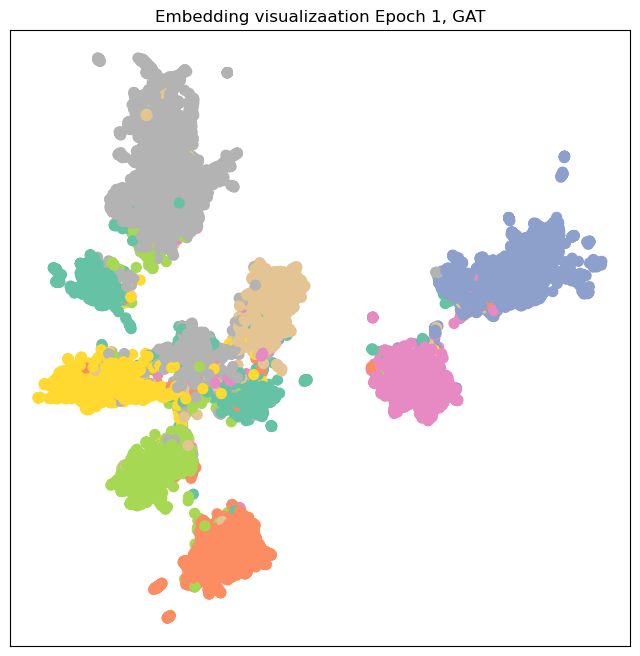

Epoch 1/10: Loss: 0.488 (train), 0.216 (val), accuracy: 0.839 (train), 0.937 (val), f1: 0.839 (train), 0.937 (val), balanced_accuracy: 0.831 (train), 0.933 (val)


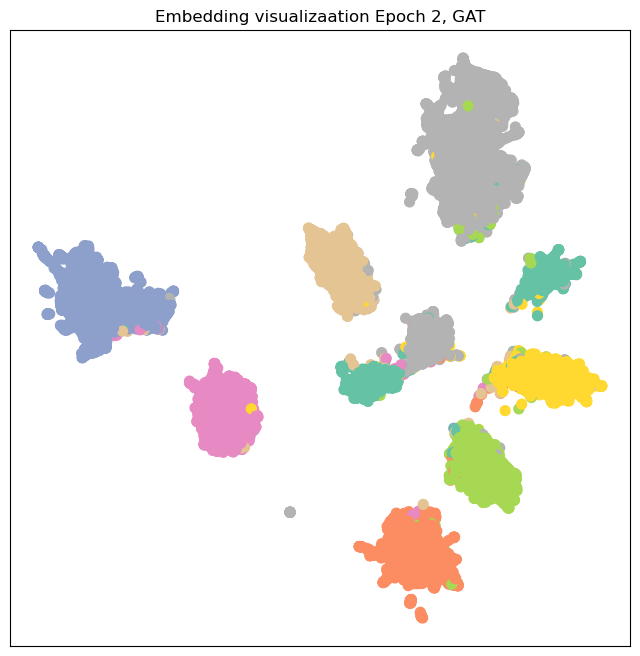

Epoch 2/10: Loss: 0.145 (train), 0.135 (val), accuracy: 0.959 (train), 0.962 (val), f1: 0.959 (train), 0.962 (val), balanced_accuracy: 0.958 (train), 0.960 (val)


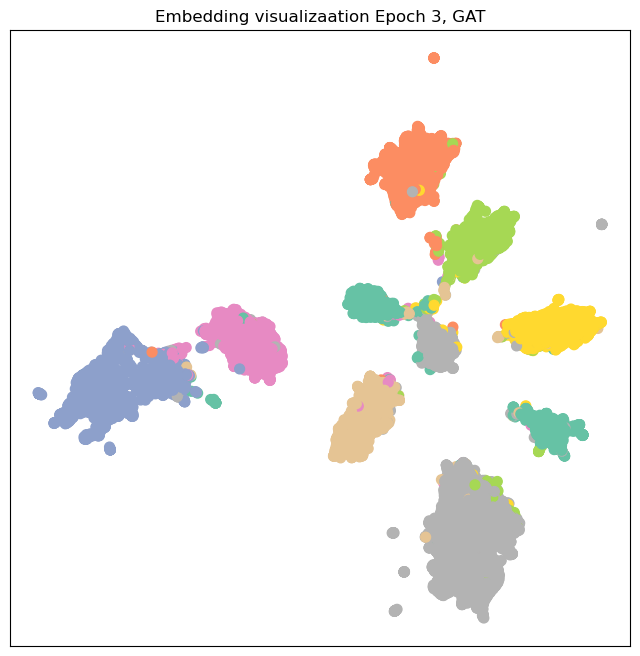

Epoch 3/10: Loss: 0.100 (train), 0.116 (val), accuracy: 0.973 (train), 0.967 (val), f1: 0.973 (train), 0.967 (val), balanced_accuracy: 0.972 (train), 0.966 (val)


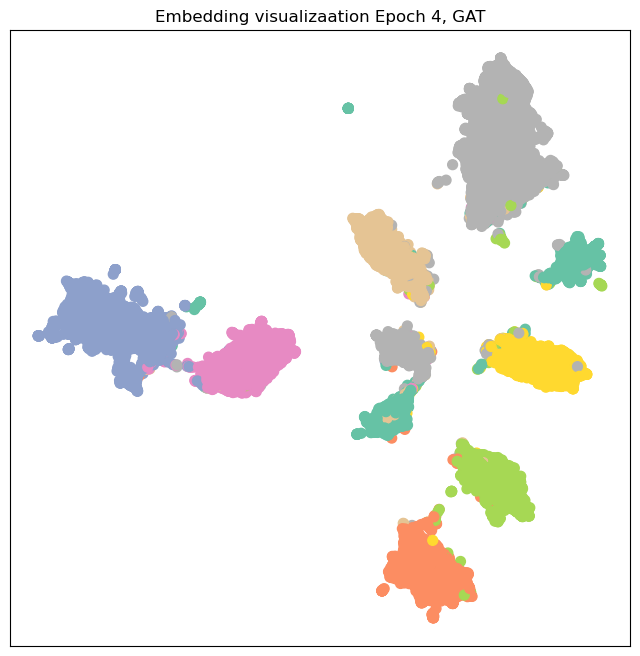

Epoch 4/10: Loss: 0.083 (train), 0.108 (val), accuracy: 0.977 (train), 0.970 (val), f1: 0.977 (train), 0.970 (val), balanced_accuracy: 0.977 (train), 0.969 (val)


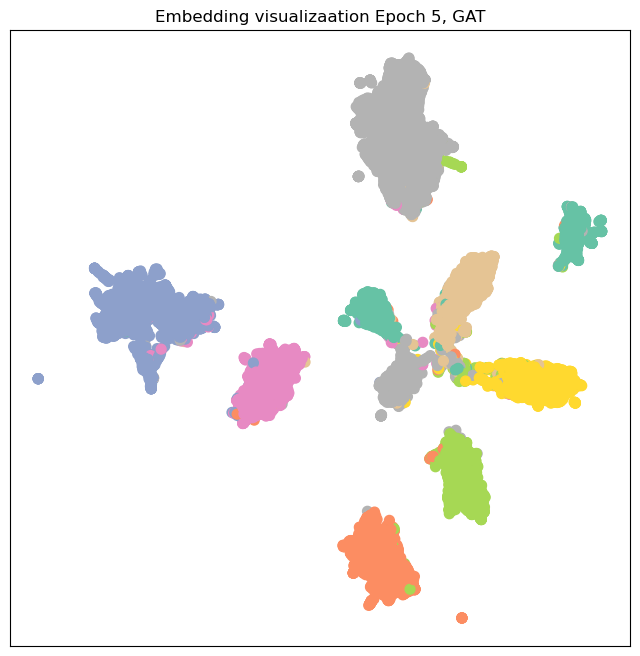

Epoch 5/10: Loss: 0.073 (train), 0.100 (val), accuracy: 0.980 (train), 0.972 (val), f1: 0.980 (train), 0.972 (val), balanced_accuracy: 0.979 (train), 0.971 (val)


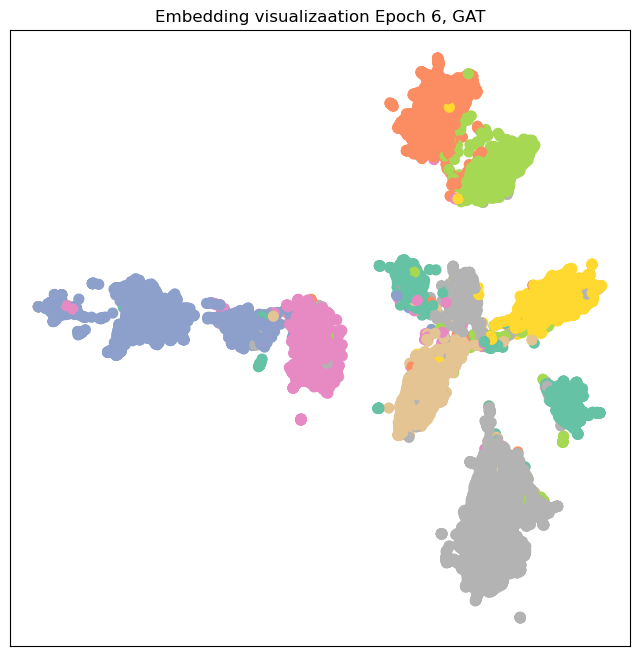

Epoch 6/10: Loss: 0.067 (train), 0.120 (val), accuracy: 0.981 (train), 0.966 (val), f1: 0.981 (train), 0.966 (val), balanced_accuracy: 0.981 (train), 0.965 (val)


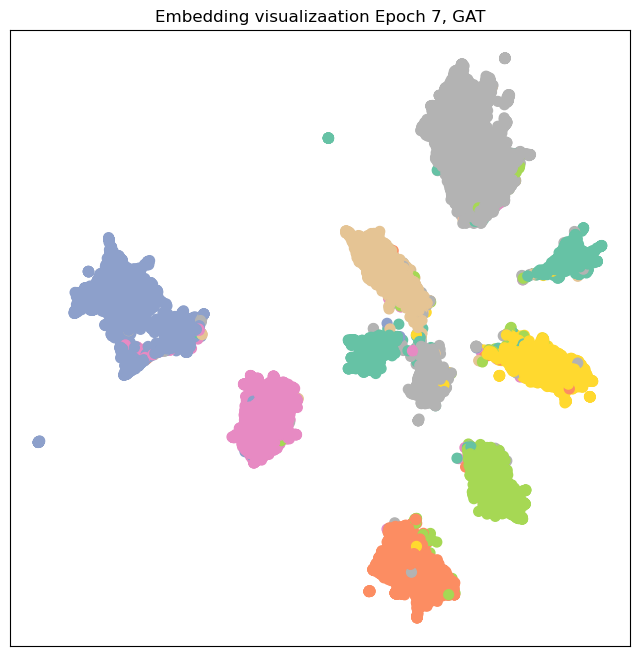

Epoch 7/10: Loss: 0.062 (train), 0.091 (val), accuracy: 0.983 (train), 0.975 (val), f1: 0.983 (train), 0.975 (val), balanced_accuracy: 0.982 (train), 0.975 (val)


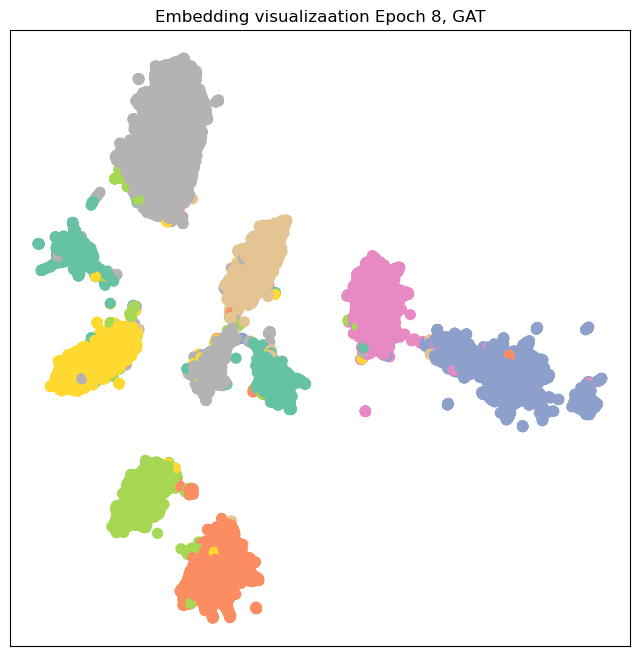

Epoch 8/10: Loss: 0.059 (train), 0.102 (val), accuracy: 0.983 (train), 0.972 (val), f1: 0.983 (train), 0.972 (val), balanced_accuracy: 0.983 (train), 0.972 (val)


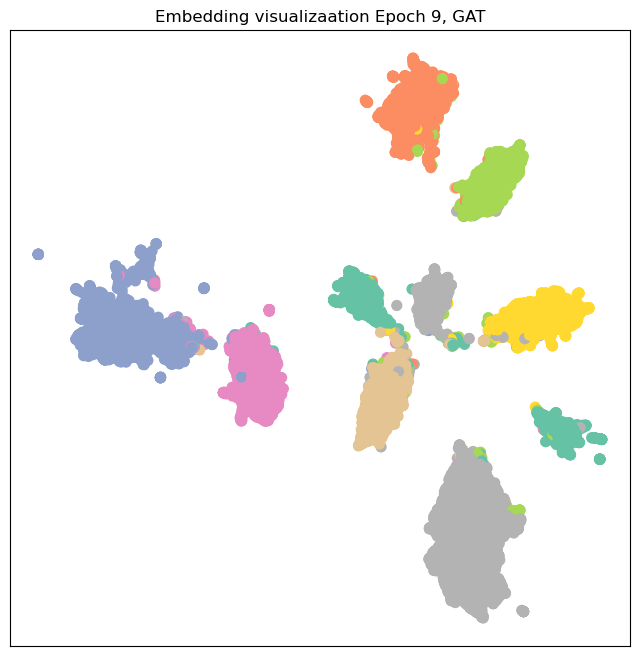

Epoch 9/10: Loss: 0.056 (train), 0.088 (val), accuracy: 0.984 (train), 0.977 (val), f1: 0.984 (train), 0.977 (val), balanced_accuracy: 0.984 (train), 0.976 (val)


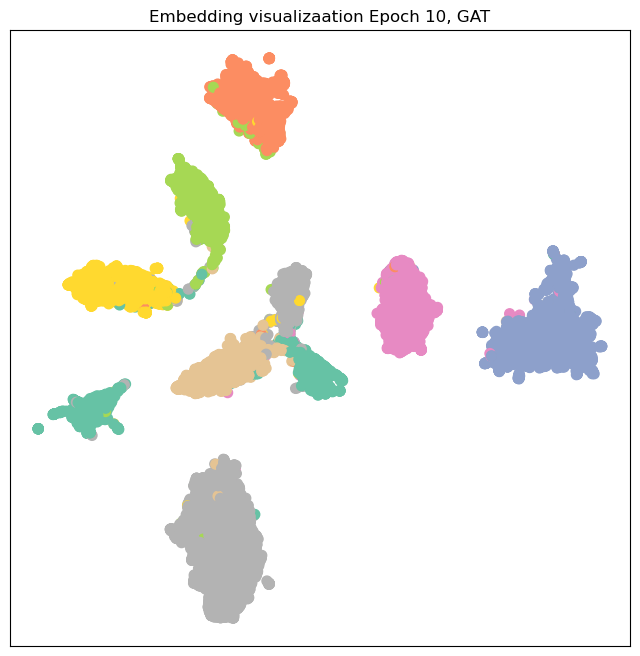

Epoch 10/10: Loss: 0.054 (train), 0.095 (val), accuracy: 0.985 (train), 0.974 (val), f1: 0.985 (train), 0.974 (val), balanced_accuracy: 0.984 (train), 0.974 (val)
Training GAT finished!


In [14]:
# testing the gnn experiment function for all models
#test = gnn_experiment(gcn, train_loader, val_loader, num_epochs=1)
test = gnn_experiment(gat, train_loader, val_loader, num_epochs=10)
# test = gnn_experiment(gin, train_loader, val_loader, num_epochs=1)
# test = gnn_experiment(gin, train_loader, val_loader, num_epochs=1)

In [15]:

# results_dict = { model.__class__.__name__: gnn_experiment(model, train_loader, val_loader, num_epochs=10) for model in model_list }


In [16]:
# saving the results per class
# torch.save(results_dict[gcn.__class__.__name__], f'output-no-cat/{gcn.__class__.__name__}-results-dict.pt')
# torch.save(results_dict[gat.__class__.__name__],f'output-no-cat/{gat.__class__.__name__}-results-dict.pt')
# torch.save(results_dict[gsage.__class__.__name__],f'output-no-cat/{gsage.__class__.__name__}-results-dict.pt')
# torch.save(results_dict[gin.__class__.__name__],f'output-no-cat/{gin.__class__.__name__}-results-dict.pt')

In [17]:
# results = gnn_experiment(gat, train_loader, val_loader, num_epochs=10)

In [24]:
# create the dict with the results for the models from the output folder
results_dict = {
    gcn.__class__.__name__: torch.load(f'output/{gcn.__class__.__name__}-results-dict.pt'),
    gat.__class__.__name__: torch.load(f'output/{gat.__class__.__name__}-results-dict.pt'),
    'GraphSAGE': torch.load(f'output/GraphSAGE-results-dict.pt'),
    gin.__class__.__name__: torch.load(f'output/{gin.__class__.__name__}-results-dict.pt'),
    'mlp': torch.load(f'output/mlp-results-dict.pt')
}

print(results_dict['mlp'])

{'model': MLP(
  (layers): ModuleList(
    (0): Linear(in_features=300, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
), 'train_losses': [0.6464078416871251, 0.4016213512114889, 0.3119984013202498, 0.2746625145611227, 0.2529330501000286, 0.23835807606932313, 0.2291889572666149, 0.22089087824799325, 0.21487407781923631, 0.20997745454414274], 'val_losses': [0.48015487395181244, 0.34749236555343965, 0.29814869844526914, 0.28092889816195793, 0.2752187261088546, 0.24544552409993672, 0.24220493145607, 0.2291258543984447, 0.23783107958962582, 0.23125079753796435], 'train_metrics_history': {'accuracy': [0.7932791532144111, 0.8745647463839481, 0.9034503429789931, 0.9151124851204494, 0.9216260886692758, 0.9262077056803487, 0.9290765686685907, 0.9318786342499422, 0.9334064108383074, 0.9347252314358874], 'f1': [0.7922570423473958, 0.8743782216785412, 0.9033855044902668, 0.9150655118091268, 0.9215872015389222, 0.9261806439919812, 0.9290464128382641, 0

/tmp/ipykernel_578022/3806434575.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gcn.__class__.__name__: torch.load(f'output/{gcn.__class__.__name__}-results-dict.pt'),


In [25]:
import matplotlib.pyplot as plt
import itertools

def plot_results(results_dict, num_epochs=10):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    axs = axs.flatten()
    epochs = range(num_epochs)

    # Define a color cycle to assign consistent colors per model
    color_cycle = itertools.cycle(
        plt.rcParams['axes.prop_cycle'].by_key()['color'])

    # Dictionary to store the color for each model
    model_colors = {}

    # Plot training and validation losses in the first subplot
    axs[0].set_title('Training Loss')
    for model_name, result in results_dict.items():
        # Assign a color to the model if it hasn't been assigned yet
        if model_name not in model_colors:
            model_colors[model_name] = next(color_cycle)

        color = model_colors[model_name]
        axs[0].plot(epochs, result['train_losses'],
                    label=f'{model_name} (train)', color=color)
        axs[0].plot(epochs, result['val_losses'],
                    label=f'{model_name} (val)', color=color, linestyle='dashed')

    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_xticks(ticks=epochs, labels=[str(i+1) for i in epochs])
    axs[0].legend()

    # Now plot the metrics in the remaining 3 subplots
    metric_names = list(next(iter(results_dict.values()))[
                        'train_metrics_history'].keys())  # Get metric names from the first model

    for i, metric_name in enumerate(metric_names):
        axs[i+1].set_title(metric_name)
        for model_name, result in results_dict.items():
            # Use the same color as for the loss plot
            color = model_colors[model_name]
            axs[i+1].plot(epochs, result['train_metrics_history']
                          [metric_name], label=f'{model_name} (train)', color=color)
            axs[i+1].plot(epochs, result['val_metrics_history'][metric_name],
                          label=f'{model_name} (val)', color=color, linestyle='dashed')

        axs[i+1].set_xlabel('Epoch')
        axs[i+1].set_ylabel(metric_name)
        axs[i+1].set_xticks(ticks=epochs, labels=[str(i+1) for i in epochs])
        axs[i+1].legend()

    plt.tight_layout()
    plt.show()


def plot_losses_and_f1(results_dict, num_epochs=10):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    epochs = range(num_epochs)

    # Define a color cycle to assign consistent colors per model
    color_cycle = itertools.cycle(
        plt.rcParams['axes.prop_cycle'].by_key()['color'])

    # Dictionary to store the color for each model
    model_colors = {}

    # Plot training and validation losses in the first subplot
    axs[0].set_title('Training Loss')
    for model_name, result in results_dict.items():
        # Assign a color to the model if it hasn't been assigned yet
        if model_name not in model_colors:
            model_colors[model_name] = next(color_cycle)

        color = model_colors[model_name]
        axs[0].plot(epochs, result['train_losses'],
                    label=f'{model_name} (train)', color=color)
        axs[0].plot(epochs, result['val_losses'],
                    label=f'{model_name} (val)', color=color, linestyle='dashed')

    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_xticks(ticks=epochs, labels=[str(i+1) for i in epochs])
    axs[0].legend()

    # Plot F1 scores in the second subplot
    axs[1].set_title('F1 Score')
    for model_name, result in results_dict.items():
        # Use the same color as for the loss plot
        color = model_colors[model_name]
        axs[1].plot(epochs, result['train_metrics_history']['f1'],
                    label=f'{model_name} (train)', color=color)
        axs[1].plot(epochs, result['val_metrics_history']['f1'],
                    label=f'{model_name} (val)', color=color, linestyle='dashed')

    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('F1 Score')
    axs[1].set_xticks(ticks=epochs, labels=[str(i+1) for i in epochs])
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def plot_f1(results_dict):
    fig, axs = plt.subplots(1, 1, figsize=(7, 7))
    epochs = range(10)

    # Define a color cycle to assign consistent colors per model
    color_cycle = itertools.cycle(
        plt.rcParams['axes.prop_cycle'].by_key()['color'])

    # Dictionary to store the color for each model
    model_colors = {}
    
    # exclude GIN from the plot
    results_dict.pop('GIN')

    # Plot F1 scores in the second subplot
    axs.set_title('F1 Score')
    for model_name, result in results_dict.items():
        #make model name capitalized
        model_name = model_name.upper()
        # Assign a color to the model if it hasn't been assigned yet
        if model_name not in model_colors:
            model_colors[model_name] = next(color_cycle)

        color = model_colors[model_name]
        axs.plot(epochs, result['val_metrics_history']['f1'],
                    label=f'{model_name} (val)', color=color, linestyle='dashed')
        axs.plot(epochs, result['train_metrics_history']['f1'],
                 label=f'{model_name} (val)', color=color)

    axs.set_xlabel('Epoch')
    axs.set_ylabel('F1 Score')
    axs.set_xticks(ticks=epochs, labels=[str(i+1) for i in epochs])
    axs.legend()

    plt.tight_layout()
    plt.show()

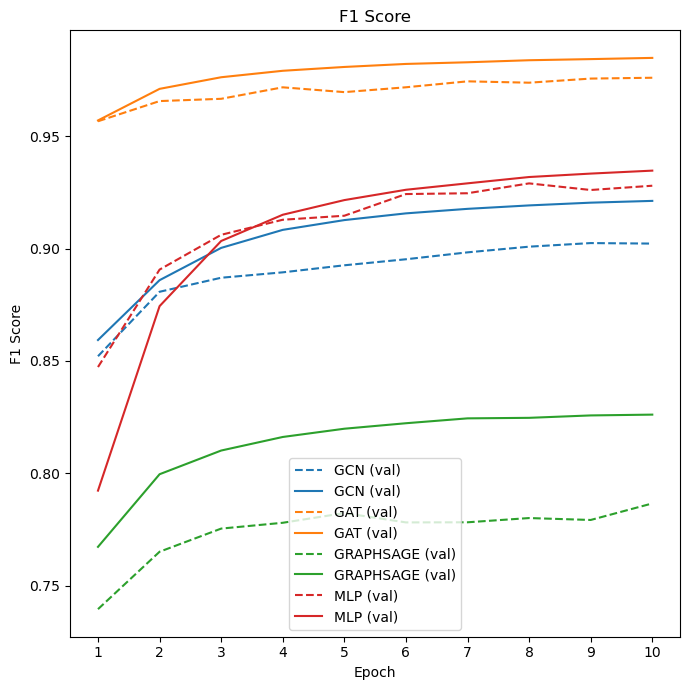

In [26]:
# plot_results(results_dict)
# plot_losses_and_f1(results_dict)
plot_f1(results_dict)

In [21]:
# # train the models and get the results
# #for model in [gcn, gat, gin, gsage]:
# results = gnn_experiment(gcn, train_loader, val_loader) 
#  # torch.save(results, f'{model.__class__.__name__}_results.pt')

In [22]:
# # put all the results in a dataframe and display it as a table where it is easy to compare the models
# results = []

# for model in [gcn, gat, gin, gsage]:
#   model_name = model.__class__.__name__
#   results.append(torch.load(f'output/{model_name}_results.pt'))
  
# results_df = pd.DataFrame(results)
# results_df['model'] = ['GCN', 'GAT', 'GIN', 'GraphSAGE']
# results_df = results_df.set_index('model')
# results_df

## Evaluation

In [27]:
def compute_test_confusion_matrix(model_name):
  with torch.no_grad():
    model = results_dict[model_name]['model']
    
    model.eval()
    all_preds = []
    all_labels = []
    
    for batch in test_loader:
      batch = batch.to(device)
      out, _ = model(batch.x, batch.edge_index)
      all_preds.append(out)
      all_labels.append(batch.y)
      
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
   
    preds = all_preds.argmax(dim=1).cpu().numpy()
    labels = all_labels.cpu().numpy()
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

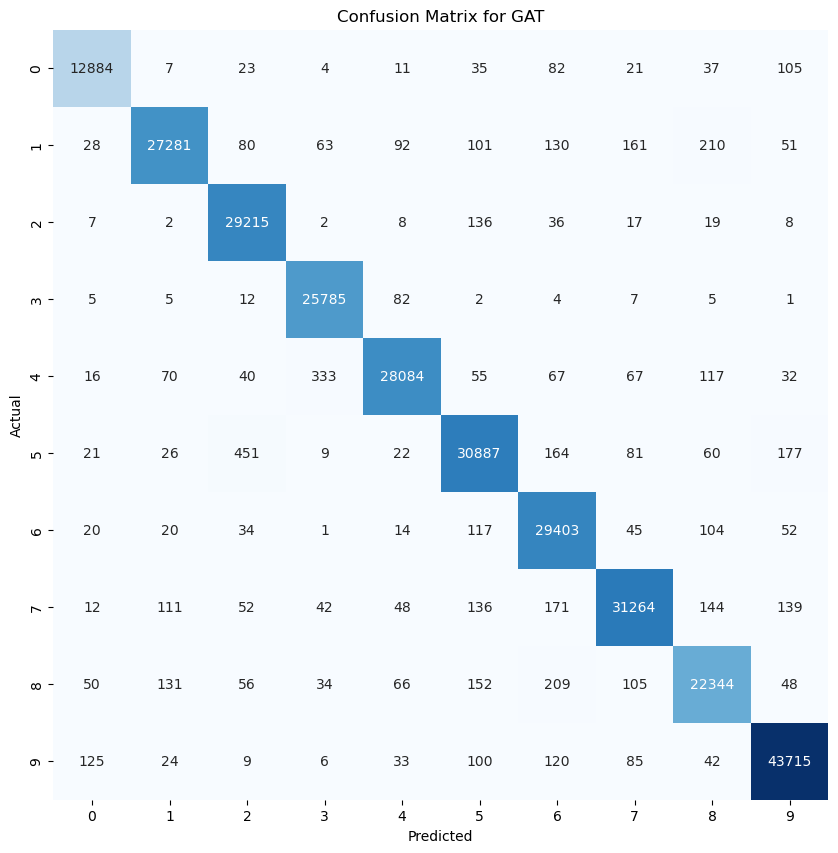

In [28]:
# test confusion matrix
compute_test_confusion_matrix(gat.__class__.__name__)

## Explanation

In [25]:
# # do the prediction for only a single sample in the dataset and use and explainer to explain the prediction

# from captum.attr import IntegratedGradients
# from captum.attr import LayerConductance
# from captum.attr import LayerIntegratedGradients
# from captum.attr import NeuronConductance
# from captum.attr import Saliency
# from captum.attr import visualization as viz

# def explain_prediction(model, data, idx):
#   # Get the model prediction
#   model.eval()
#   with torch.no_grad():
#     out, h = model(data.x, data.edge_index)
#     pred = out.argmax(dim=1)
#     pred_prob = torch.softmax(out, dim=1).max().item()
#     print(f'Predicted class: {pred.item}, Probability: {pred_prob:.3f}')
    
#   # Create an IntegratedGradients object for the model
#   ig = IntegratedGradients(model)
  
#   # Compute the attributions
#   attributions_ig = ig.attribute(data.x, target=pred, n_steps=200)
  
#   # Visualize the attributions
#   _ = viz.visualize_node_weights(data.x.cpu(), attributions_ig.cpu(), method='blended_heat_map', cmap='coolwarm')
  
#   return attributions_ig

In [29]:
# read amazon raw data from the parquet file
raw_data = pd.read_parquet('data/amazon_product_data.parquet')
filtered_data = pd.read_parquet(
    'data/amazon_product_data_top_categories.parquet')
index_to_asin = np.load('index_to_asin.npy', allow_pickle=True).item()

In [27]:
# change the asin such that we have the index as key and the asin as value
filtered_data.iloc[196]['asin']

'B0026KAIDG'

In [47]:
# encode the main catorgy with the label encoder, and show the corresponding label to the number of the class
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
filtered_data['main_category_encoded'] = le.fit_transform(
    filtered_data['main_category'])

# print the the top 10 classes by number of samples
print(filtered_data['main_category'].unique())
print('-------------------------------')
# print(raw_data['main_category'].value_counts().head(10))

# print the related encoded class
print(filtered_data['main_category_encoded'].unique())

['Sports & Outdoors' 'Home & Kitchen' 'Toys & Games'
 'Health & Personal Care' 'Tools & Home Improvement' 'Electronics'
 'Cell Phones & Accessories' 'Arts, Crafts & Sewing' 'Automotive' 'Beauty']
-------------------------------
[7 6 9 5 8 4 3 0 1 2]


Node 106 - Predicted Class: 2, True Class: 2
Nodes within 3 hops of Node 106: [106, 4, 109, 112, 115, 120, 122]
Node 106 Neighbors: [  4 109 112]
Node 106 Neighbors Classes: tensor([5, 5, 5])


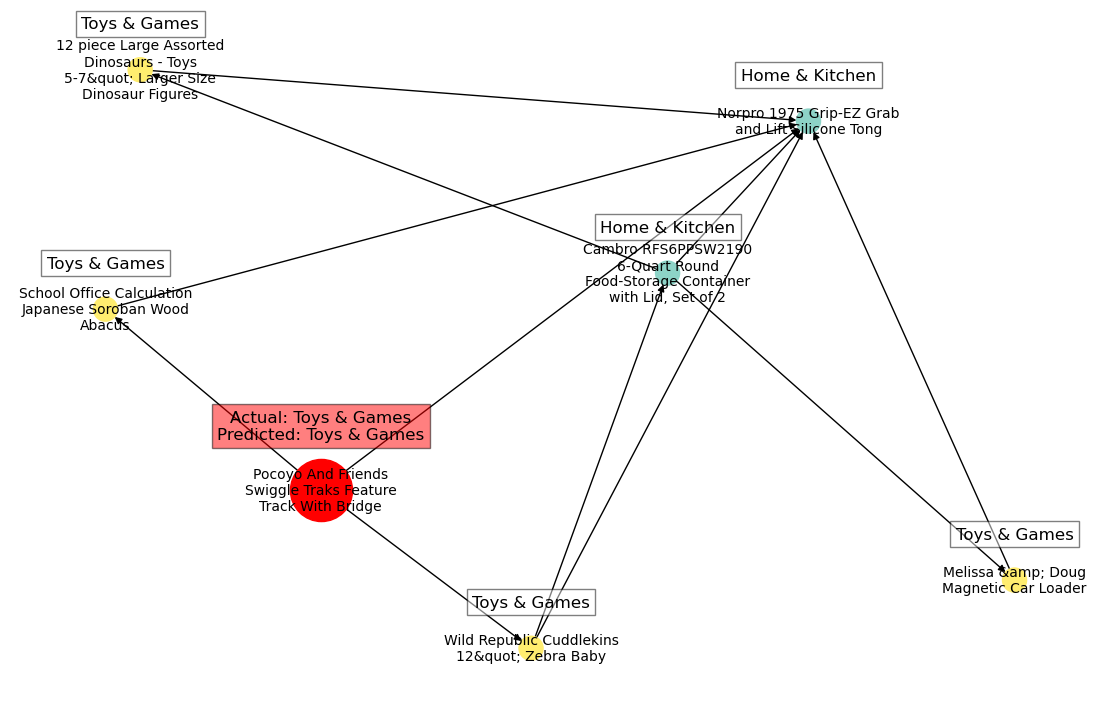

In [92]:
from torch_geometric.utils import to_networkx
import networkx as nx

model: GAT = results_dict[gat.__class__.__name__]['model']

# Model is now trained; let's use it to predict the class of a node
model.eval()
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

# Add a function to wrap text
def wrap_text(text, max_line_length=40):
    """
    Wrap the text by inserting newline characters after every max_line_length characters.
    """
    words = text.split()  # Split the text into words
    wrapped_text = ""
    current_line = ""

    for word in words:
        if len(current_line) + len(word) + 1 > max_line_length:
            wrapped_text += current_line + "\n"
            current_line = word  # Start a new line
        else:
            if current_line:
                current_line += " " + word
            else:
                current_line = word

    # Append the last line
    wrapped_text += current_line

    return wrapped_text


# Get one batch of test data
data = next(iter(test_loader))

# Convert PyG data to NetworkX graph
G = to_networkx(data)

# Ensure node_idx has at least 2 neighbors
valid_node_idx = None
min_num_neighbors = 3
for node in range(data.num_nodes):
    # Get neighbors of the node
    neighbors = list(G.neighbors(node))
    if len(neighbors) >= min_num_neighbors:
        valid_node_idx = node
        break

# If no such node is found, raise an error
if valid_node_idx is None:
    raise ValueError(
        f"No node with at least {min_num_neighbors} neighbors found in the graph.")

node_idx = valid_node_idx

# Get logits and predicted class
# Unpack, assuming logits are the first element
logits, _ = model(data.x, data.edge_index)

predicted_class = logits[node_idx].argmax(dim=0).item()
true_class = data.y[node_idx].item()

print(f"Node {node_idx} - Predicted Class: {predicted_class}, True Class: {true_class}")

# Get the nodes within a radius of 3 hops from the selected node
radius = 3
nodes_within_radius = [n for n, dist in nx.single_source_shortest_path_length(
    G, node_idx, cutoff=radius).items() if dist <= radius]

print(f"Nodes within {radius} hops of Node {node_idx}: {nodes_within_radius}")

# Visualize the subgraph with the selected node and its neighbors within the radius
subgraph = G.subgraph(nodes_within_radius)

# assign the related features for each node in the networkx graph "subgraph"
for n in subgraph.nodes():
  # get the related product from the row data, thorugh the asin
  asin = index_to_asin[n]
  title = raw_data[raw_data['asin'] == asin]['title'].values[0]
  main_category = raw_data[raw_data['asin'] == asin]['main_category'].values[0]
  
  subgraph.nodes[n]['title'] = wrap_text(title, max_line_length=25)
  subgraph.nodes[n]['main_category'] = main_category
  

plt.figure(figsize=(11, 7))
pos = nx.spring_layout(subgraph, seed=42)  # Layout for the subgraph
node_colors = [data.y[n].item() for n in nodes_within_radius]
nx.draw(subgraph, pos, node_color=node_colors,
cmap=plt.get_cmap('Set3'), node_size=300, with_labels=True, labels=nx.get_node_attributes(subgraph, 'title'), font_size=10)


# Highlight the selected node in a larger size and red color
nx.draw_networkx_nodes(subgraph, pos, nodelist=[node_idx], node_color='red', node_size=2000)

# Add a custom label for the selected node showing actual and predicted class, color-coded
classes = filtered_data['main_category'].unique()
label_text = f'Actual: {classes[true_class]}\nPredicted: {classes[predicted_class]}'

# Use matplotlib's annotation to add the label near the node
x, y = pos[node_idx]
plt.text(x, y+0.18, label_text, fontsize=12, ha='center', va='center', 
         bbox=dict(facecolor='red', alpha=0.5, edgecolor='black'))

# for each neighbor, print the main category in the same format as the selected node
for n in nodes_within_radius:
  x, y = pos[n]
  if n != node_idx:
    plt.text(x, y+0.13, f'{subgraph.nodes[n]["main_category"]}', fontsize=12, ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

# Print node features and neighbors
# print(f"Node {node_idx} Features: {data.x[node_idx]}")
neighbors_within_radius = data.edge_index[1][data.edge_index[0] == node_idx].cpu().numpy()
print(f"Node {node_idx} Neighbors: {neighbors_within_radius}")
print(f"Node {node_idx} Neighbors Classes: {data.y[neighbors_within_radius]}")

In [30]:
# get the node text data of the node selected
def print_info(idx):
  node_info = raw_data.iloc[idx]
  print(f'Node {idx}: {node_info["title"]} ({node_info["main_category"]})')

print_info(node_idx)
print('-------------------')

for node_index in neighbors_within_radius:
    print_info(node_index)

Node 106: Master Class Non-Stick 2 Litre Pudding Steamer KCMCHB61 (Home & Kitchen)
-------------------
Node 4: Girls Ballet Tutu Neon Blue (Sports & Outdoors)
Node 109: HP 10bII+ Financial Calculator (NW239AA) (Office Products)
Node 112: Belkin 36-Piece Demagnetized Computer Tool Kit  with Case (Black) (Electronics)


In [31]:
# put the raw data in the node data and the neighbors data, and then plot again with the title info instead of the node index

# Get the node features and neighbors
for node in [node_idx] + neighbors_within_radius.tolist():
    print_info(node)
    print('-------------------')
    
# draw them in the graph

Node 106: Master Class Non-Stick 2 Litre Pudding Steamer KCMCHB61 (Home & Kitchen)
-------------------
Node 4: Girls Ballet Tutu Neon Blue (Sports & Outdoors)
-------------------
Node 109: HP 10bII+ Financial Calculator (NW239AA) (Office Products)
-------------------
Node 112: Belkin 36-Piece Demagnetized Computer Tool Kit  with Case (Black) (Electronics)
-------------------
